In [1]:
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [2]:
conn = sqlite3.connect('instacart.db')

In [3]:
c = conn.cursor()

In [4]:
c.execute("select * from orders;")
print (c.fetchone())

(2168274, 2, 1, 2, 11, None)


In [5]:
c.execute("select * from aisles;")
print (c.fetchone())

(0, 1, 'prepared soups salads')


In [6]:
c.execute("select * from departments;")
print (c.fetchone())

(0, 1, 'frozen')


In [7]:
c.execute("select * from departments;")
print (c.fetchall())

[(0, 1, 'frozen'), (1, 2, 'other'), (2, 3, 'bakery'), (3, 4, 'produce'), (4, 5, 'alcohol'), (5, 6, 'international'), (6, 7, 'beverages'), (7, 8, 'pets'), (8, 9, 'dry goods pasta'), (9, 10, 'bulk'), (10, 11, 'personal care'), (11, 12, 'meat seafood'), (12, 13, 'pantry'), (13, 14, 'breakfast'), (14, 15, 'canned goods'), (15, 16, 'dairy eggs'), (16, 17, 'household'), (17, 18, 'babies'), (18, 19, 'snacks'), (19, 20, 'deli'), (20, 21, 'missing')]


## 1. Orders

### when do customer order? 

<BarContainer object of 7 artists>

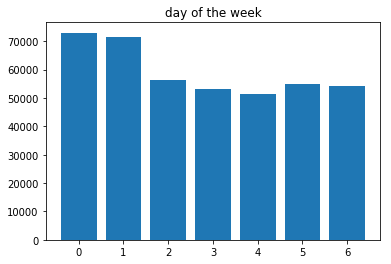

In [8]:
c.execute('''
select order_dow,count(order_id) from orders group by order_dow;
''')
dist = c.fetchall()
dow = [d for d,v in dist]
count = [v for d,v in dist]
plt.title("day of the week")
plt.bar(x = dow, height = count)

<BarContainer object of 24 artists>

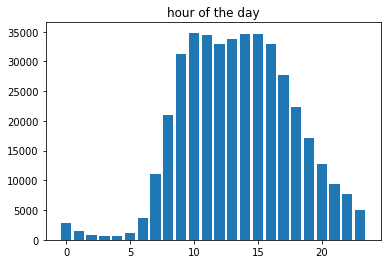

In [9]:
c.execute('''
select order_hour_of_day,count(order_id) from orders group by order_hour_of_day;
''')
dist = c.fetchall()
key = [d for d,v in dist]
count = [v for d,v in dist]
plt.title("hour of the day")
plt.bar(x = key, height = count)

### all customers reorder

In [10]:
# all customers reorder
c.execute('''
select * from orders where days_since_prior_order is null
and user_id not in (select user_id from orders where days_since_prior_order is not null);
''')
print (c.fetchall())

[]


### how often do customers reorder?

<BarContainer object of 31 artists>

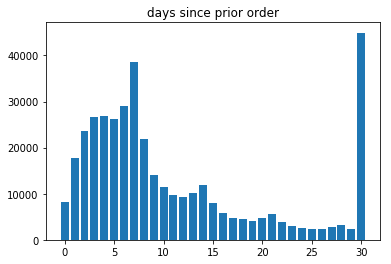

In [11]:
c.execute('''
select days_since_prior_order,count(order_id) from orders 
where days_since_prior_order is not null
group by days_since_prior_order;
''')
dist = c.fetchall()
key = [d for d,v in dist]
count = [v for d,v in dist]
plt.title("days since prior order")
plt.bar(x = key, height = count)

### who are the most loyal customers, and who are the new comers?

In [12]:
c.execute('''
select user_id, count(user_id)
from orders
group by user_id
order by 2 desc
limit 5
''')
dist = c.fetchall()
print ("the most loyal customers")
for k,v in dist:
    print ("user {} ordered {} times".format(k,v))

c.execute('''
select user_id, count(user_id)
from orders
group by user_id
order by 2 
limit 5
''')
dist = c.fetchall()
print ("the new customers")
for k,v in dist:
    print ("user {} ordered {} times".format(k,v))

the most loyal customers
user 786 ordered 100 times
user 4711 ordered 100 times
user 5329 ordered 100 times
user 6045 ordered 100 times
user 6398 ordered 100 times
the new customers
user 8 ordered 4 times
user 119 ordered 4 times
user 428 ordered 4 times
user 490 ordered 4 times
user 491 ordered 4 times


### customer's order frequency distribution

<BarContainer object of 97 artists>

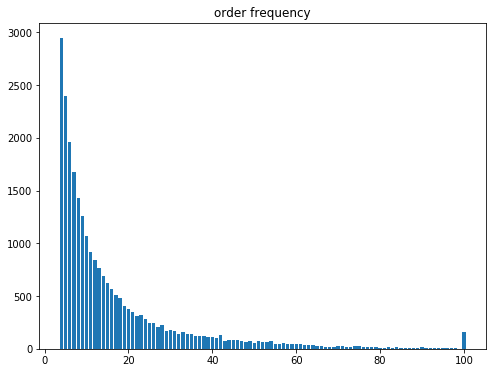

In [13]:
c.execute('''
select cnt, count(user_id) from
(select user_id, count(user_id) cnt
from orders
group by user_id)
group by cnt;
''')
dist = c.fetchall()
key = [d for d,v in dist]
count = [v for d,v in dist]
plt.figure(figsize = (8,6))
plt.title("order frequency")
plt.bar(x = key, height = count)

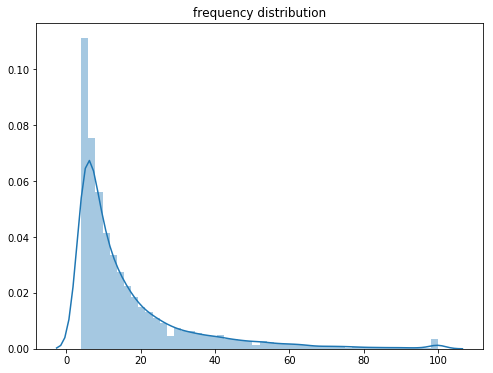

In [14]:
c.execute('''
select count(user_id) cnt
from orders
group by user_id
''')
dist = c.fetchall()
value = [x[0] for x in dist]
plt.figure(figsize = (8,6))

plt.title("frequency distribution")
sns.distplot(value)

## 2. Orders and Products

### what are the top 10 most ordered items?

<BarContainer object of 10 artists>

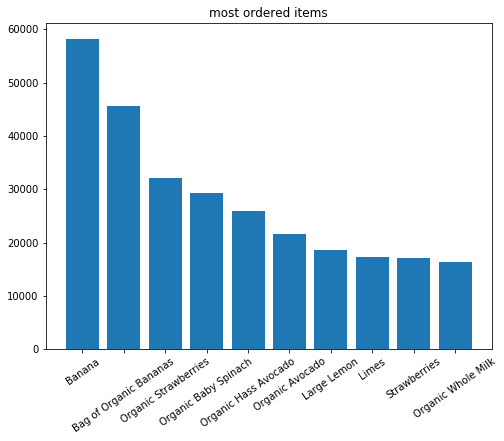

In [15]:
c.execute('''
select product_name, cnt from
(select product_id, count(distinct order_id) cnt
from order_products 
group by product_id
order by 2 desc 
limit 10) left join products using (product_id)
''')
dist = c.fetchall()
key = [k for k,v in dist]
count = [v for k,v in dist]
plt.figure(figsize=(8,6))
plt.xticks(rotation = 35)
plt.title("most ordered items")
plt.bar(x = key, height = count)

### what about the most popular item for each department?

In [16]:
c.execute('''
select department, product_name from
(select department_id, product_id, product_name, max(cnt) mx from
(select p.department_id, o.product_id, product_name,count(order_id) cnt
from order_products o left join products p using (product_id)
group by p.department_id, p.product_id)
group by department_id) left join departments using (department_id)
''')
dist = c.fetchall()
for k,v in dist:
    print ("Category {}: {}".format(k,v))

Category frozen: Blueberries
Category other: Roasted Almond Butter
Category bakery: 100% Whole Wheat Bread
Category produce: Banana
Category alcohol: Sauvignon Blanc
Category international: Organic Sea Salt Roasted Seaweed Snacks
Category beverages: Sparkling Water Grapefruit
Category pets: Grain Free Chicken Formula Cat Food
Category dry goods pasta: Marinara Sauce
Category bulk: Dried Mango
Category personal care: Lavender Hand Soap
Category meat seafood: Boneless Skinless Chicken Breasts
Category pantry: Extra Virgin Olive Oil
Category breakfast: Honey Nut Cheerios
Category canned goods: Organic Black Beans
Category dairy eggs: Organic Whole Milk
Category household: 100% Recycled Paper Towels
Category babies: Baby Food Stage 2 Blueberry Pear & Purple Carrot
Category snacks: Lightly Salted Baked Snap Pea Crisps
Category deli: Original Hummus
Category missing: Organic Riced Cauliflower


### what are somethings that are usually bought together? based on 390K orders

In [17]:
c.execute('''
select order_id, product_name 
from order_products left join products using (product_id);
''')
dist = c.fetchall()

In [18]:
items = {}
for k,v in dist:
    if k not in items:
        items[k] = [v]
    else:
        items[k].append(v)

In [19]:
dataset = list(items.values())

In [20]:
sample_dataset = dataset[:50]

In [21]:
te = TransactionEncoder()
# te_ary = te.fit(dataset).transform(dataset)
# df = pd.DataFrame(te_ary, columns=te.columns_)
# df.head()

# oht_ary = te.fit(dataset).transform(dataset, sparse=True)
# sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
# sparse_df

,#2 Coffee Filters,#2 Cone White Coffee Filters,#2 Mechanical Pencils,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,(70% Juice!) Mountain Raspberry Juice Squeeze,+Energy Black Cherry Vegetable & Fruit Juice,".5\"" Waterproof Tape",0 Calorie Fuji Apple Pear Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,...,with Sweet Cinnamon Bunches Cereal,with Twist Ties Sandwich & Storage Bags,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water,with a Splash of Pineapple Coconut Water
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
sparse_df[:5]

,#2 Coffee Filters,#2 Cone White Coffee Filters,#2 Mechanical Pencils,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,(70% Juice!) Mountain Raspberry Juice Squeeze,+Energy Black Cherry Vegetable & Fruit Juice,".5\"" Waterproof Tape",0 Calorie Fuji Apple Pear Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,...,with Sweet Cinnamon Bunches Cereal,with Twist Ties Sandwich & Storage Bags,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with Xylitol Original Flavor 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water,with a Splash of Pineapple Coconut Water
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389767,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
389768,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
389769,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
389770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
#from mlxtend.frequent_patterns import fpgrowth
fp_df = fpgrowth(sparse_df, min_support=0.001, use_colnames=True)
fp_df[:5]

,support,itemsets
0,0.023232,(Carrots)
1,0.021017,(Michigan Organic Kale)
2,0.006429,(Organic Egg Whites)
3,0.001986,(Garlic Powder)
4,0.007815,(Original Orange Juice)


In [25]:
fp_df["length"] = fp_df["itemsets"].apply(lambda x: len(x))

In [35]:
fp_df = fp_df.sort_values("support",ascending= False)

In [41]:
fp_df[fp_df["length"]>2][:10]

,support,itemsets,length
2479,0.004746,"(Bag of Organic Bananas, Organic Strawberries, Organic Hass Avocado)",3
2480,0.003761,"(Bag of Organic Bananas, Organic Baby Spinach, Organic Hass Avocado)",3
2052,0.003505,"(Organic Strawberries, Organic Raspberries, Bag of Organic Bananas)",3
2192,0.003474,"(Organic Strawberries, Organic Baby Spinach, Bag of Organic Bananas)",3
2054,0.003461,"(Bag of Organic Bananas, Organic Raspberries, Organic Hass Avocado)",3
1886,0.003104,"(Banana, Organic Baby Spinach, Organic Avocado)",3
1888,0.003053,"(Banana, Organic Strawberries, Organic Avocado)",3
2191,0.002773,"(Banana, Organic Strawberries, Organic Baby Spinach)",3
2481,0.002576,"(Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado)",3
2053,0.002555,"(Organic Strawberries, Organic Raspberries, Organic Hass Avocado)",3


we can surface these products so customers can add them to carts on 1 click!

# to do 
recommend based on shopping frequency?
user clustering and rec based on clustering
collaborative filtering